In [1]:

import os

import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import csv
from glob import glob
import fnmatch
import logging
import multiprocessing
import random
from multiprocessing.pool import Pool
import librosa
from shutil import move
import nltk
import torch
import soundfile as sf
from sklearn.model_selection import train_test_split

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets
!pip install transformers
!pip install jiwer
!pip uninstall transformers[torch] accelerate -y
!pip install transformers[torch] accelerate
!pip install evaluate


--------------------------------------------------------------------------------------------

# Load dataset

In [4]:
from datasets import load_dataset, concatenate_datasets
dataset = load_dataset("Hani89/medical_asr_recording_dataset", split="train[:800]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
from collections import Counter

def check_duplicate_transcriptions(dataset):
    transcriptions = dataset['sentence']

    transcription_counts = Counter(transcriptions)

    duplicates = {transcription: count for transcription, count in transcription_counts.items() if count > 1}

    return duplicates

duplicates = check_duplicate_transcriptions(dataset)
print(duplicates)

{'I feel dizzy after doing a muscular effort.': 4, 'I break out on my face very frequently': 2, 'Sometimes my body feels week without reason': 2, 'There feels like a swollen knot at my shoulderblade with pain shooting from that': 2, 'When I get out of bed in the morning my body feels very weak.': 5, 'My knee feels weak and it gave way the other day at the top of the stairs.  Luckily there was a rail to hold on to.': 2, 'The pain in my ear is unbearable.': 3, 'When I wake up in the morning I feel a soreness in my body': 3, 'My stomach aches when I eat hot food, why?': 2, "I have a blurry vision and i can't see in the darkness , what is the reason doctor ?": 4, 'I feel pain in my shoulders when I write on the keyboard.': 4, 'I have a split on my thumb that will not heal.': 2, "I'm in need for a treatment for my hair fall": 2, 'My mind feels very sad, as if it hurts.  The way I feel in my head is awful and when I think about my break-up, I cry with sadness.': 2, 'I feel dizzy when i make 

In [6]:
len(duplicates)

223

In [7]:
def check_null_values(dataset):
    df = dataset.to_pandas()

    return df.isnull().sum().to_dict()

null_counts = check_null_values(dataset)
null_counts

{'audio': 0, 'sentence': 0}

In [8]:
dataset = dataset.train_test_split(test_size = 0.3)

In [9]:
print(dataset['train']['audio'][0]['sampling_rate'])


16000


In [10]:
from datasets import Dataset, Audio

device = 'cuda' if torch.cuda.is_available() else'cpu'

In [11]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).upper() + " "
    batch["sentence"] = batch['sentence'].rstrip()
    return batch

dataset = dataset.map(remove_special_characters)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [12]:
import json
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=1,
    keep_in_memory=True,
    remove_columns=dataset.column_names['train']
)

vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
print(vocab_dict)

vocab_dict["|"] = vocab_dict[" "]
del vocab_dict [" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))


Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

{'S': 0, 'D': 1, 'R': 2, 'L': 3, 'A': 4, 'M': 5, 'N': 6, 'W': 7, 'I': 8, 'C': 9, 'G': 10, 'Y': 11, 'P': 12, "'": 13, 'T': 14, 'H': 15, 'V': 16, 'U': 17, 'O': 18, 'K': 19, ' ': 20, 'E': 21, 'F': 22, 'B': 23}
26


In [13]:
from datasets import ClassLabel
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=14):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [14]:
show_random_elements(dataset["train"].remove_columns(["audio"]))

,sentence
0,WHEN I CARRY HEAVY THINGS I FEEL LIKE BREAKING MY BACK
1,I FEEL STRONG PAIN IN MY KNEE AFTER IT WAS HIT DURING THE FOOTBALL MATCH
2,HEARING ANY LOUD SOUNDS MAKES MY EAR ACHES
3,MY DAUGHTER HAD HER EYEBROWS THREADED AND IT PULLED AN OPENING OF SKIN IN ONE OF HER BROWS THAT IS NOW PUFFY AND OOZING
4,THERE IS A SHARP PAIN IN MY CALVE
5,THE NERVES WERE SO DAMAGED DURING THE OPERATION ON MY ANKLE THAT I CANNOT STAND BEING TOUCHED ON THE SCAR
6,I WAS PLAYING BASKETBALL YESTERDAY I HAVE SPRAINED ANKLE
7,HEARING ANY LOUD SOUNDS MAKES MY EAR ACHES
8,MY NECK HURTS ME AND I CAN'T LOOK DOWN OR UP
9,I FEEL DIZZY AFTER DOING A MUSCULAR EFFORT


------------------------------------------------------------------------------------

### Feature Extractor and Tokenizer

In [15]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [16]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-100h")

Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav

In [17]:
print(processor.tokenizer.get_vocab())


{"'": 27, '</s>': 2, '<pad>': 0, '<s>': 1, '<unk>': 3, 'A': 7, 'B': 24, 'C': 19, 'D': 14, 'E': 5, 'F': 20, 'G': 21, 'H': 11, 'I': 10, 'J': 29, 'K': 26, 'L': 15, 'M': 17, 'N': 9, 'O': 8, 'P': 23, 'Q': 30, 'R': 13, 'S': 12, 'T': 6, 'U': 16, 'V': 25, 'W': 18, 'X': 28, 'Y': 22, 'Z': 31, '|': 4}


# Without Fine-tune

In [18]:

device = 'cuda' if torch.cuda.is_available() else'cpu'


def add_predicted_text(example):
    audio_array = example["audio"]["array"]
    sampling_rate = example["audio"]["sampling_rate"]

    inputs = processor(audio_array, sampling_rate=sampling_rate, return_tensors="pt")

    with torch.no_grad():
      logits = model(**inputs).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    example["pred_text"] = transcription[0]

    return example



In [19]:
result = dataset['test'].map(add_predicted_text)

Parameter 'function'=<function add_predicted_text at 0x7ad82e4c3640> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

---------------------------------------------------------------------------------------------------------

In [20]:
result

Dataset({
    features: ['audio', 'sentence', 'pred_text'],
    num_rows: 240
})

In [21]:
from datasets import load_metric
wer_metric = load_metric("wer")

<ipython-input-21-7b292a9c8d88>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [22]:
predictions = [pred for pred in result["pred_text"]]
references = [ref for ref in result["sentence"]]

In [23]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=predictions, references=references)))

Test WER: 0.375


In [24]:
show_random_elements(result.remove_columns(["audio"]))

,sentence,pred_text
0,I HAVE A CUT THAT HAS BECOME RED AND OOZES PUSS,I HAVE A CUP THAT HAS BECOME RED AND EASLY POP
1,MY BICEPS STARTED ACHING AFTER I WENT TO THE GYM,MY BISUP STARTED ACHING AFTER I WENT TO THE JIM
2,THERE'S SWELLING IN MY NECK AND IT HURTS,THERE IS SWELLING IN MY NECK AND IT HURTS
3,I FEEL DIZZY AFTER DOING A MUSCULAR EFFORT,I FEEL DIZZY AFTER DOING A MUSCULAR EFFORT
4,HOW DO YOU KNOW IF YOU HAVE A TORN MENISCUS IN YOUR KNEE,HOW DO YOU KNOW IF YOU HAVE AN TAUTEN MANY SCUSTS IN YOUR NEE
5,I CARRIED A HEAVY BAG YESTERDAY AND WHEN I GET UP TODAY I FELT A GREAT SHOULDER PAIN,I CARRIED A HEAVY BAG YESTERDAY AND WHEN I GET UP TO DAY I FELT A GREAT SHOULDER PAN
6,I HAVE A GREAT PAIN IN MY FOOT LIKE THROMBING PAIN WITH RELAXING MY PAIN RELEIF,I HAVE A GREAT BAN IN MY FUT LIE CLUMBING BIN WIT DELAPSING MY BINDERLY
7,I CAN'T WALK WELL I HAVE AN ACHE IN MY FOOT,I KIN WOLK WO I HAVE O'ME ACHIN MY FRUIT
8,I HAVE THE IMPRESSION OF HAVING NO STRENGTH IN MY BODY,I HAVE THE IMPRESSION OF HAVING NO STRENGTH IN MY BODY
9,THE NERVES WERE SO DAMAGED DURING THE OPERATION ON MY ANKLE THAT I CANNOT STAND BEING TOUCHED ON THE SCAR,THE NERVE WHERE SO DAMAGE DURING THE OPERATION OF MY IDCLE THUT I CAN NOT STAND BEING TOUCH ON THE SCAR


# Fine-tune

## Preprocess data

In [25]:
def prepare_dataset(batch):

    audio = batch["audio"]

    batch["input_values"] = processor(
        audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"].upper()).input_ids

    return batch

In [26]:
encoded_dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names['train'], num_proc=1)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [27]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 560
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 240
    })
})

In [28]:

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [29]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding="longest")

In [30]:
from datasets import load_metric

import evaluate
wer_evaluate = evaluate.load('wer')

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False, skip_special_tokens=True)

    # pred_str_norm = [pred for pred in pred_str]
    # label_str_norm = [label for label in label_str]
    wer = wer_evaluate.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [31]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, Wav2Vec2Config

try:
    del model
except NameError:
    pass


def model_init():
    model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-100h", ctc_loss_reduction="mean",pad_token_id=processor.tokenizer.pad_token_id)
    return model


In [32]:
model = model_init()

Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav

### Best parameters

In [33]:
#!pip install optuna

In [34]:
# def hp_space_optuna(trial):
#     return {
#         "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
#         "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4,8]),
#         "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
#         "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 6)
#     }

In [35]:

import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from transformers import TrainingArguments, AdamW, Trainer

optimizer = AdamW(model.parameters(), lr=1e-5)

best_learning_rate = 4.070153999582437e-05
best_weight_decay = 0.12336175777385361

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/training",
    group_by_length=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    num_train_epochs=6,
    save_steps=50,  #
    eval_steps=50,  #  determina a frequência com que a avaliação do modelo será realizada durante o treino
    logging_steps=50,
    learning_rate=best_learning_rate,
    max_steps=200,
    weight_decay=best_weight_decay,
    warmup_steps=50,
    fp16=True, # so se tiver a usar gpu
    gradient_accumulation_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    gradient_checkpointing=True,
)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
from transformers import TrainerCallback

class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
            #print(f"Training loss at step {state.global_step}: {logs['loss']}")  # Adiciona log de debug

        if 'eval_loss' in logs:
            self.val_losses.append(logs['eval_loss'])
            #print(f"Validation loss at step {state.global_step}: {logs['eval_loss']}")  # Adiciona log de debug


    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In [38]:
from transformers import EarlyStoppingCallback
class CustomEarlyStoppingCallback(EarlyStoppingCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        super().on_evaluate(args, state, control, **kwargs)
        if self.early_stopping_patience <= state.best_model_checkpoint:
            self.logger.info(f"Early stopping triggered at epoch {state.epoch} with best model checkpoint at {state.best_model_checkpoint}")


In [39]:
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3, # Número de avaliações sem melhoria antes de parar o treino
    early_stopping_threshold=0.01# Mudança mínima para considerar melhoria
)


In [40]:

metrics_logger = LossLoggerCallback()

trainer = Trainer(
    #model = model,
    model_init=model_init,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=processor.feature_extractor,
    callbacks= [metrics_logger, early_stopping],
)



Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav

In [41]:
# # Perform hyperparameter search
# best_trial = trainer.hyperparameter_search(
#     direction="minimize",  # or "maximize" depending on your metric
#     hp_space=hp_space_optuna,
#     backend="optuna",  # You can also use "ray", "sigopt", etc.
#     n_trials=2 # Number of trials
# )


In [42]:
# print("Best trial parameters:")
# for key, value in best_trial.hyperparameters.items():
#     print(f"{key}: {value}")



In [43]:
train_result = trainer.train()

Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav

Step,Training Loss,Validation Loss,Wer
50,1.081500,0.638864,0.415873
100,0.832000,0.577935,0.365873
150,0.758100,0.544998,0.343254
200,0.619700,0.523318,0.330159


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of 

In [44]:
save_path = '/content/drive/MyDrive/models/wav2vec-base-100'
trainer.save_model(save_path)

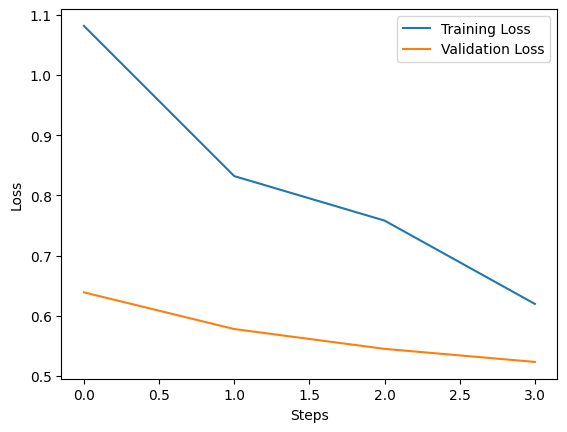

In [45]:
metrics_logger.plot_losses()


# Evaluate

In [46]:
model_save = Wav2Vec2ForCTC.from_pretrained("/content/drive/MyDrive/models/wav2vec-base-100")

para o audio feito por nós

In [47]:
original_text_airport = "TRAGIC END PERSON KILLED AT AMSTERDAM AIRPORT WAS AIRLINE EMPLOYEE WHO INTENTIONALLY CLIMBED INTO JET ENGINE"
original_text_health = "Today I fell to the ground and twisted my foot".upper()

original_text_thesun = "Best lung cancer drug halts tumours giving years to dying patients".upper()

In [49]:
import torch
import torchaudio
def add_predicted_text_to_audio(audio_path):
    audio_array, sampling_rate = torchaudio.load(audio_path)

    if sampling_rate != processor.feature_extractor.sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=processor.feature_extractor.sampling_rate)
        audio_array = resampler(audio_array)
        sampling_rate = processor.feature_extractor.sampling_rate

    inputs = processor(audio_array.squeeze().numpy(), sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    with torch.no_grad():
        logits = model_save(**inputs).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)

    return transcription[0]


**first audio**

In [48]:
audio_airport = "audio_airport_robot.wav"

In [50]:
transcription = add_predicted_text_to_audio(audio_airport)
print(f"Transcrição: {transcription}")

Transcrição: TRAGIC END PERSON KILLED AT AMSTER DAM AIRPORT WAS ALLINE IMPLOY WHO INTENTIONALLY CLIMBED INTO JETENGIN


In [51]:
transcription_list = [transcription]
original_text_list = [original_text_airport]

In [52]:
wer_metric = load_metric("wer")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [53]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=transcription_list, references=original_text_list)))

Test WER: 0.375


**second audio**

In [54]:
audio_health = "audio_health.wav"

In [55]:
transcription2 = add_predicted_text_to_audio(audio_health)
print(f"Transcrição: {transcription2}")

Transcrição: TO DAY I FELL TO THE GROUNDAND TWISTED MY FOOT


In [56]:
transcription_list2 = [transcription2]
original_text_list = [original_text_health]

In [57]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=transcription_list2, references=original_text_list)))


Test WER: 0.400


**third** **audio**

In [58]:
audio_health_thesun = "audio_health_thesun.wav"

In [59]:
transcription3 = add_predicted_text_to_audio(audio_health_thesun)
print(f"Transcrição: {transcription3}")

Transcrição: BEST LUNG CANSER DRUG HOLDS HUMORS GIVING YEARS TO DYING PATIENCE


In [60]:
transcription_list3 = [transcription3]
original_text_list = [original_text_thesun]

In [61]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=transcription_list3, references=original_text_list)))


Test WER: 0.364


**dataset de teste**

In [62]:
test_dataset = load_dataset("Hani89/medical_asr_recording_dataset", split="test[:100]")

In [63]:
test_dataset = test_dataset.map(remove_special_characters)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [64]:
device = 'cuda' if torch.cuda.is_available() else'cpu'


def add_predicted_text(example):
    audio_array = example["audio"]["array"]
    sampling_rate = example["audio"]["sampling_rate"]

    inputs = processor(audio_array, sampling_rate=sampling_rate, return_tensors="pt")
    inputs = inputs.to(device=model.device)

    with torch.no_grad():
      logits = model_save(**inputs).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    example["pred_text"] = transcription[0]

    return example



In [65]:
result = test_dataset.map(add_predicted_text)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [66]:
predictions = [pred for pred in result["pred_text"]]
references = [ref for ref in result["sentence"]]

In [67]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=predictions, references=references)))

Test WER: 0.228


In [68]:
result

Dataset({
    features: ['audio', 'sentence', 'pred_text'],
    num_rows: 100
})

In [69]:
def to_lower(example):
    example['pred_text'] = example['pred_text'].lower()

    example['sentence'] = example['sentence'].lower()
    return example

result = result.map(to_lower)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [70]:
def add_file_column(batch):

    audio = batch["audio"]

    batch["file"] = audio["path"]

    return batch

In [71]:
result = result.map(add_file_column)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [72]:
result

Dataset({
    features: ['audio', 'sentence', 'pred_text', 'file'],
    num_rows: 100
})

In [73]:
show_random_elements(result.remove_columns(["file","audio"]))

,sentence,pred_text
0,i wake up at night feeling cold,i wake up at night feeling cold
1,my chest break out with red pimples and whiteheads,my head wike ahump with rap pampi'm i ha
2,i am having problems seeing things feel like a cloud on my eyes everything is blurry,i am having problem seeing things feel like a cloud on my eyes everything is blutry
3,when i play sports i have some burning sensation in my spine,when i play spolts i have some burnding sensation in my pine
4,i feel a clicking sensation in my knee each time i step,i feel a clicking sensation in my knee each time i step
5,i have pimples on my back,i have pimples on my back
6,my hand open wound got infected,my hig uppen wone would iv it
7,i have eruptions on my face that come and go,i have eruptions on my face that come and go
8,i feel congestion in my chest,i feel conjestion in my chest
9,oh my heart hurts me i tried to be calm and i can't,oh my heuart hurts me i try to be calm and i can't


In [74]:
result = result.remove_columns("audio")

In [75]:
result.to_csv("results_medical.csv", index = False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

13818